Please note that this example focuses on the raw data utilized for Myelinating Schwann Cells (mSCs) in the Dorsal Root Ganglion. 
#### By: Saniya Khullar, Xiang Huang, Raghu Ramesh, John Svaren, Daifeng Wang
##### University of Wisconsin - Madison

In [1]:
printdf = lambda *args, **kwargs: print(pd.DataFrame(*args, **kwargs))
rng_seed = 2023 # random seed for reproducibility
randSeed = 123
from packages_needed import *
import error_metrics as em 
from packages_needed import *
import Netrem_model_builder as nm
import DemoDataBuilderXandY as demo
import PriorGraphNetwork as graph
import netrem_evaluation_functions as nm_eval
import essential_functions as ef


## Input Datasets for NetREm

In [2]:
# file names (FNs) of input data:
tfs_for_tgs_FN = "myelin_candidate_TFs_for_TGs.parquet"
train_data_FN = "myelin_training_gene_expression_data.parquet"
test_data_FN = "myelin_testing_gene_expression_data.parquet"
ppi_FN = "ppi_dataframe.parquet"

A list of potential candidate TFs for each given target gene (TG). Please note that we constructed this input list of candidate TFs for the respective TGs using various data sources such as motif binding analysis, colocalization of TFs, molecular function, etc.

In [3]:
# list of potential candidate TFs for each given target gene (TG)
tfs_for_tgs_final_df = pd.read_parquet(tfs_for_tgs_FN)
tfs_for_tgs_final_df

,TG,TF
0,A1BG,CREB3L2
1,A1BG,CTCF
2,A1BG,ELF2
3,A1BG,GTF3C2
4,A1BG,IRF3
...,...,...
635390,ZZZ3,BACH1
635391,ZZZ3,TCF3
635392,ZZZ3,ERF
635393,ZZZ3,ZNF281


Single-cell gene expression data that is cell samples by genes:

In [4]:
train_gexpr = pd.read_parquet(train_data_FN)
train_gexpr

,Unnamed: 0,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,C1orf159,...,STK26,RTL8B,RTL8C,RTL8A,SMIM10L2B,SMIM10L2A,INTS6L,ADGRG4,PNMA6A,CCNQ
0,ATCGCCTAGTAGATCA-1_1,0.0,0.0,0.0,0,0,1.232599,0.0,0.0,0.795283,...,0,0,0.000000,0,0,0,0.0,0,0,0.0
1,ATGAGGGCATGGGAAC-1_4,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.000000,...,0,0,0.000000,0,0,0,0.0,0,0,0.0
2,GGGACCTCAGACAAAT-1_3,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.000000,...,0,0,0.000000,0,0,0,0.0,0,0,0.0
3,CGATGGCCAGATCCTA-1_5,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.000000,...,0,0,2.517899,0,0,0,0.0,0,0,0.0
4,AATCGACGTGGCACTC-1_5,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.000000,...,0,0,0.000000,0,0,0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,GGGAAGTAGCTTAAGA-1_2,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,2.360130,...,0,0,0.000000,0,0,0,0.0,0,0,0.0
219,GGAACCCGTCACTTCC-1_4,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.000000,...,0,0,0.000000,0,0,0,0.0,0,0,0.0
220,CGGGTCACAAACGGCA-1_2,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.000000,...,0,0,0.000000,0,0,0,0.0,0,0,0.0
221,CACCAAACATAGAATG-1_1,0.0,0.0,0.0,0,0,1.267693,0.0,0.0,0.822562,...,0,0,0.000000,0,0,0,0.0,0,0,0.0


In [5]:
test_gexpr = pd.read_parquet(test_data_FN)
test_gexpr

,Unnamed: 0,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,C1orf159,...,STK26,RTL8B,RTL8C,RTL8A,SMIM10L2B,SMIM10L2A,INTS6L,ADGRG4,PNMA6A,CCNQ
0,CCCAACTGTCGAATTC-1_5,0.000000,0.0,0.0,0,0,0.000000,0.000000,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0
1,GTTCGCTGTACAGTTC-1_1,0.000000,0.0,0.0,0,0,0.000000,0.000000,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0
2,AGGAGGTCATTGACTG-1_2,0.000000,0.0,0.0,0,0,0.840949,0.840949,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0
3,TAAGTCGTCTTCGTGC-1_3,0.000000,0.0,0.0,0,0,0.000000,0.000000,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0
4,GCCAGCATCAGAGCAG-1_2,0.000000,0.0,0.0,0,0,0.000000,0.000000,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,AAGGAATCACGGGCTT-1_3,0.000000,0.0,0.0,0,0,0.000000,0.000000,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0
92,ATAGAGATCAAAGGTA-1_2,0.000000,0.0,0.0,0,0,0.000000,0.000000,0.0,1.048932,...,0,0,0.0,0,0,0,0.0,0,0,0.0
93,TTTGTTGTCTACGCGG-1_2,0.000000,0.0,0.0,0,0,1.001498,0.000000,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0
94,GCCATGGGTGGAACAC-1_1,0.000000,0.0,0.0,0,0,1.973762,0.000000,0.0,0.000000,...,0,0,0.0,0,0,0,0.0,0,0,0.0


Input Protein-Protein Interaction (PPI) Network:

In [6]:
ppi_df = pd.read_parquet(ppi_FN)
ppi_df

,TF1,TF2,score
323,NR2C2,NR2C1,1.000000
432,NR2C1,NR2C2,1.000000
545,ATF7,ATF2,1.000000
572,CUX1,ATF2,1.000000
573,JUND,ATF2,1.000000
...,...,...,...
23168702,TEAD1,TEAD4,0.922923
24614146,NFIA,NFIB,0.812813
28106670,MEF2C,MEF2B,0.912209
28172345,NFIB,NFIA,0.983943


Next, please note that we will use NetREm (Network Regression Embeddings) to identify the optimal Transcription Factors (TFs) out of the N candidate TFs, which may regulate this TG.
NetREm is run 1 TG at a time, to eventually build out networks for the cell-type :)

### Integration of multimodal data and networks:

In [7]:
tg = "ZZZ3" # target gene of interest

In [8]:
# training gene expression data for target gene (TG) y
y_train = train_gexpr[[tg]]
y_train

,ZZZ3
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
218,0.0
219,0.0
220,0.0
221,0.0


In [9]:
# testing gene expression data for target gene (TG) y
y_test = test_gexpr[[tg]]
y_test

,ZZZ3
0,0.000000
1,1.406272
2,0.000000
3,0.000000
4,0.000000
...,...
91,0.000000
92,0.000000
93,0.000000
94,0.000000


In [10]:
candidate_TFs_for_TG_df = tfs_for_tgs_final_df[tfs_for_tgs_final_df["TG"] == tg]
num_candidate_TFs_for_TG = candidate_TFs_for_TG_df.shape[0]
print(f":) Please note that we have N = {num_candidate_TFs_for_TG} candidate TFs for our TG {tg}")
candidate_TFs_for_TG_df

:) Please note that we have N = 77 candidate TFs for our TG ZZZ3


,TG,TF
635318,ZZZ3,CTCF
635319,ZZZ3,E2F3
635320,ZZZ3,EBF1
635321,ZZZ3,FOXP1
635322,ZZZ3,GTF3C2
...,...,...
635390,ZZZ3,BACH1
635391,ZZZ3,TCF3
635392,ZZZ3,ERF
635393,ZZZ3,ZNF281


In [11]:
candidate_TFs_for_TG = list(candidate_TFs_for_TG_df["TF"]) 
candidate_TFs_for_TG.sort() # Saniya sorts alphabetically for convenience :)
print(f"Some of the first few candidate TFs for the TG {tg}: {candidate_TFs_for_TG[0:6]}")

Some of the first few candidate TFs for the TG ZZZ3: ['BACH1', 'BCL6', 'CCNT2', 'CTCF', 'E2F3', 'E4F1']


Please note that we will utilize this given data to fit our network regularized regression problem for our target gene (TG):

**NetREm model training:**
* filtered_ppi_for_TG
* X_train
* y_train

**NetREm model testing:**
* X_test
* y_test

In [12]:
# we filter the PPI to only include the candidate TFs for our TG
filtered_ppi_for_TG = ppi_df[ppi_df["TF1"].isin(candidate_TFs_for_TG)]
filtered_ppi_for_TG = filtered_ppi_for_TG[filtered_ppi_for_TG["TF2"].isin(candidate_TFs_for_TG)].drop_duplicates()
filtered_ppi_for_TG

,TF1,TF2,score
32314,HCFC1,SP1,1.000000
32369,SMC3,SP1,1.000000
32387,HDAC2,SP1,1.000000
32457,GTF3C2,SP1,1.000000
32619,MGA,SP1,1.000000
...,...,...,...
14290770,ZFP82,TP53,0.219219
14292496,ZNF136,SMC3,0.157157
14293375,ZNF274,HDAC2,0.245245
14293598,ZNF281,SMAD4,0.183183


In [13]:
# # Then, we need to do this conversion for NetREm:
filtered_ppi_for_TG = filtered_ppi_for_TG.values.tolist()
filtered_ppi_for_TG

[['HCFC1', 'SP1', 1.0],
 ['SMC3', 'SP1', 1.0],
 ['HDAC2', 'SP1', 1.0],
 ['GTF3C2', 'SP1', 1.0],
 ['MGA', 'SP1', 1.0],
 ['HCFC1', 'E4F1', 1.0],
 ['HDAC2', 'E4F1', 1.0],
 ['GTF3C2', 'E4F1', 1.0],
 ['SP1', 'E4F1', 1.0],
 ['RXRB', 'E4F1', 1.0],
 ['SIN3A', 'E4F1', 1.0],
 ['RFX3', 'E4F1', 1.0],
 ['PML', 'E4F1', 1.0],
 ['SREBF2', 'E4F1', 1.0],
 ['HCFC1', 'RORA', 1.0],
 ['GTF3C2', 'RORA', 1.0],
 ['HCFC1', 'ESR1', 1.0],
 ['GTF3C2', 'ESR1', 1.0],
 ['STAT1', 'ESR1', 1.0],
 ['GTF3C2', 'TP53', 1.0],
 ['HCFC1', 'SIN3A', 1.0],
 ['HDAC2', 'SIN3A', 1.0],
 ['GTF3C2', 'SIN3A', 1.0],
 ['SP1', 'SIN3A', 1.0],
 ['MAX', 'SIN3A', 1.0],
 ['MXI1', 'SIN3A', 1.0],
 ['HCFC1', 'HDAC2', 1.0],
 ['MAX', 'HDAC2', 1.0],
 ['SIN3A', 'HDAC2', 1.0],
 ['RREB1', 'HDAC2', 1.0],
 ['MGA', 'HDAC2', 1.0],
 ['SMC3', 'TP53', 1.0],
 ['SMC3', 'REST', 1.0],
 ['HDAC2', 'REST', 1.0],
 ['HCFC1', 'FOXO1', 1.0],
 ['HCFC1', 'CCNT2', 1.0],
 ['SMC3', 'CCNT2', 1.0],
 ['HDAC2', 'CCNT2', 1.0],
 ['SIN3A', 'CCNT2', 1.0],
 ['HCFC1', 'CTCF', 1.0],
 ['

In [14]:
X_train = train_gexpr[candidate_TFs_for_TG]
X_train

,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,EGR1,ELF1,ERF,...,YY1,ZBTB7A,ZFP28,ZFP82,ZNF136,ZNF140,ZNF274,ZNF281,ZNF682,ZNF76
0,0.795283,0.000000,0.795283,0.000000,1.956615,0.0,0.0,0.0,0.795283,0.0,...,0.795283,0.000000,0.000000,0.0,0.000000,0.000000,0.795283,0.0,0.0,0.0
1,0.000000,2.167218,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,2.517899,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,1.297927,1.297927,0.0,0.0,0.0,2.195567,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.757196,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
219,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,2.478969,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
220,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,1.734546,0.000000,0.0,0.0,0.0
221,0.000000,2.158477,0.822562,0.000000,0.000000,0.0,0.0,0.0,0.822562,0.0,...,0.822562,0.000000,0.000000,0.0,0.822562,0.000000,0.822562,0.0,0.0,0.0


In [15]:
X_test = test_gexpr[candidate_TFs_for_TG]
X_test

,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,EGR1,ELF1,ERF,...,YY1,ZBTB7A,ZFP28,ZFP82,ZNF136,ZNF140,ZNF274,ZNF281,ZNF682,ZNF76
0,0.000000,2.536981,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
1,1.406272,2.326511,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,1.406272,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.96871,0.000000
2,0.840949,0.840949,0.000000,0.840949,0.000000,0.000000,0.0,0.0,0.840949,0.0,...,0.840949,0.000000,0.0,0.000000,0.840949,0.0,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.000000,2.326094,0.000000,0.000000,1.726143,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,1.726143,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
4,1.893136,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.893136,0.0,...,1.340271,0.000000,0.0,1.340271,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.000000,0.000000,2.889145,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,3.554086,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
92,0.000000,1.048932,0.000000,0.000000,1.048932,0.000000,0.0,0.0,1.048932,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
93,1.001498,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.001498,0.000000,0.00000,1.001498
94,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,1.410707,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.410707,0.00000,0.000000


## Example 1 is about using defaults when possible :)

### Example 1a: 
#### Using the defaults for *beta_net* $\beta_{net}$ and *alpha_lasso* $\alpha_{lasso}$ .

In [16]:
filtered_ppi_for_TG

[['HCFC1', 'SP1', 1.0],
 ['SMC3', 'SP1', 1.0],
 ['HDAC2', 'SP1', 1.0],
 ['GTF3C2', 'SP1', 1.0],
 ['MGA', 'SP1', 1.0],
 ['HCFC1', 'E4F1', 1.0],
 ['HDAC2', 'E4F1', 1.0],
 ['GTF3C2', 'E4F1', 1.0],
 ['SP1', 'E4F1', 1.0],
 ['RXRB', 'E4F1', 1.0],
 ['SIN3A', 'E4F1', 1.0],
 ['RFX3', 'E4F1', 1.0],
 ['PML', 'E4F1', 1.0],
 ['SREBF2', 'E4F1', 1.0],
 ['HCFC1', 'RORA', 1.0],
 ['GTF3C2', 'RORA', 1.0],
 ['HCFC1', 'ESR1', 1.0],
 ['GTF3C2', 'ESR1', 1.0],
 ['STAT1', 'ESR1', 1.0],
 ['GTF3C2', 'TP53', 1.0],
 ['HCFC1', 'SIN3A', 1.0],
 ['HDAC2', 'SIN3A', 1.0],
 ['GTF3C2', 'SIN3A', 1.0],
 ['SP1', 'SIN3A', 1.0],
 ['MAX', 'SIN3A', 1.0],
 ['MXI1', 'SIN3A', 1.0],
 ['HCFC1', 'HDAC2', 1.0],
 ['MAX', 'HDAC2', 1.0],
 ['SIN3A', 'HDAC2', 1.0],
 ['RREB1', 'HDAC2', 1.0],
 ['MGA', 'HDAC2', 1.0],
 ['SMC3', 'TP53', 1.0],
 ['SMC3', 'REST', 1.0],
 ['HDAC2', 'REST', 1.0],
 ['HCFC1', 'FOXO1', 1.0],
 ['HCFC1', 'CCNT2', 1.0],
 ['SMC3', 'CCNT2', 1.0],
 ['HDAC2', 'CCNT2', 1.0],
 ['SIN3A', 'CCNT2', 1.0],
 ['HCFC1', 'CTCF', 1.0],
 ['

In [17]:
%%time 
# added %%time above time the amount of time to run the code in the cell block

# Using defaults for beta and alpha:
netrem_1a = nm.netrem(edge_list = filtered_ppi_for_TG)

# Fitting the gregulnet model on training data: X_train and y_train:
netrem_1a.fit(X_train, y_train)

# Analyzing the NetREm Function
final_model_1a = netrem_1a.model_nonzero_coef_df
print(f"# of TFs with non-zero coefficients: {netrem_1a.num_final_predictors}")
mse_train = netrem_1a.test_mse(X_train, y_train)
mse_test = netrem_1a.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")
final_model_1a

using beta_net default of 1
using alpha_lasso default of 0.01
# of TFs with non-zero coefficients: 55
Training MSE: 0.4028411980913493
Testing MSE: 0.7056823978412833
CPU times: total: 31.2 ms
Wall time: 90.6 ms


,y_intercept,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,ERF,...,STAT5B,TBX2,TCF3,TP53,USF1,YY1,ZBTB7A,ZNF140,ZNF682,ZNF76
0,None,0.091637,0.000514,0.049703,-0.0584,0.181601,-0.206912,-0.034205,0.122034,-0.089625,...,0.078489,0.007029,-0.127275,-0.103115,0.041395,0.106009,-0.03576,0.092999,0.002658,0.139763


In [18]:
netrem_1a

NetREmModel(verbose=False, overlapped_nodes_only=False, all_pos_coefs=False, model_type=Lasso, use_network=True, fit_y_intercept=False, max_lasso_iterations=10000, view_network=False, tolerance=0.0001, lasso_selection=cyclic, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192B44A58A0>)

In [19]:
print("To view the TF-TG regulatory links for the optimal TFs, please note that we can access this:")
netrem_1a.combined_df

To view the TF-TG regulatory links for the optimal TFs, please note that we can access this:


,coef,TF,TG,info,train_mse,beta_net,alpha_lasso,AbsoluteVal_coefficient,Rank,final_model_TFs,TFs_input_to_model,original_TFs_in_X
0,None,y_intercept,ZZZ3,netrem_no_intercept,0.402841,1,0.01,NaN,56,55,77,77
1,0.091637,BACH1,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.091637,17,55,77,77
2,0.000514,BCL6,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.000514,55,55,77,77
3,0.049703,CCNT2,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.049703,29,55,77,77
4,-0.0584,CTCF,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.058400,25,55,77,77
5,0.181601,E2F3,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.181601,3,55,77,77
6,-0.206912,E4F1,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.206912,1,55,77,77
7,-0.034205,EBF1,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.034205,36,55,77,77
8,0.122034,ELF1,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.122034,7,55,77,77
9,-0.089625,ERF,ZZZ3,netrem_no_intercept,0.402841,1,0.01,0.089625,19,55,77,77


In [20]:
netrem_1a.get_params()

{'info': 'NetREm Model',
 'alpha_lasso': 0.01,
 'beta_net': 1,
 'fit_y_intercept': False,
 'model_type': 'Lasso',
 'max_lasso_iterations': 10000,
 'network': <PriorGraphNetwork.PriorGraphNetwork at 0x192b44a5ed0>,
 'verbose': False,
 'all_pos_coefs': False,
 'model_info': 'fitted_model :)',
 'target_gene_y': 'ZZZ3',
 'tolerance': 0.0001,
 'lasso_selection': 'cyclic'}

In [21]:
vars(netrem_1a).keys() # to view all of the keys we may call

dict_keys(['info', 'verbose', 'overlapped_nodes_only', 'num_cv_folds', 'num_jobs', 'all_pos_coefs', 'model_type', 'use_network', 'fit_y_intercept', 'max_lasso_iterations', 'view_network', 'model_info', 'target_gene_y', 'tolerance', 'lasso_selection', 'lassocv_eps', 'lassocv_n_alphas', 'lassocv_alphas', 'beta_net', 'network', 'alpha_lasso', 'optimal_alpha', 'prior_network', 'preprocessed_network', 'network_params', 'network_nodes_list', 'kwargs', 'X_df', 'gene_expression_nodes', 'common_nodes', 'final_nodes', 'gexpr_nodes_added', 'gexpr_nodes_to_add_for_net', 'filter_network_bool', 'A_df', 'A', 'nodes', 'network_info', 'M', 'N', 'X_train', 'y_train', 'B_train', 'B_interaction_df', 'B_train_times_M', 'X_tilda_train', 'y_tilda_train', 'X_training_to_use', 'y_training_to_use', 'regr', 'final_alpha', 'coef', 'predY_tilda_train', 'mse_tilda_train', 'predY_train', 'mse_train', 'model_coef_df', 'model_nonzero_coef_df', 'sorted_coef_df', 'corr_vs_coef_df', 'final_corr_vs_coef_df', 'combined_df'

In [22]:
print(f":) We can view the sorted B-matrix of TF-TF interaction for N = {num_candidate_TFs_for_TG} TFs ", end="")
print(f"for TG {tg} where beta_net = {netrem_1a.beta_net}.")

:) We can view the sorted B-matrix of TF-TF interaction for N = 77 TFs for TG ZZZ3 where beta_net = 1.


In [23]:
b_matrix_1a = nm.organize_B_interaction_network(netrem_1a)
b_matrix_1a

,TF1,TF2,B_train_weight,sign,potential_interaction,absVal_B,info,candidate_TFs_N,target_gene_y,num_final_predictors,model_type,beta_net,gene_data,rank,percentile
2092,FOXO1,NFIB,1.119274e+00,:),:(,1.119274e+00,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,1.0,99.982912
1028,NFIB,FOXO1,1.119274e+00,:),:(,1.119274e+00,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,1.0,99.982912
4416,NFIB,SREBF2,9.570243e-01,:),:(,9.570243e-01,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,3.0,99.948735
2136,SREBF2,NFIB,9.570243e-01,:),:(,9.570243e-01,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,3.0,99.948735
1046,RORA,FOXO1,9.287842e-01,:),:(,9.287842e-01,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,5.0,99.914559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,TCF3,RXRB,-1.163842e-06,:(,:( competitive (-),1.163842e-06,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,5847.0,0.085441
960,PML,ESRRA,-9.827955e-07,:(,:( competitive (-),9.827955e-07,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,5849.0,0.051265
2784,ESRRA,PML,-9.827955e-07,:(,:( competitive (-),9.827955e-07,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,5850.0,0.034176
4708,ESR2,TCF3,-9.284305e-07,:(,:( competitive (-),9.284305e-07,B matrix of TF-TF interactions,77,ZZZ3,55,Lasso,1,training gene expression data,5851.0,0.017088


Please note that the original B matrix provided by NetREm for the above dataframe can be accessed as:

In [24]:
netrem_1a.B_interaction_df

,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,EGR1,ELF1,ERF,...,YY1,ZBTB7A,ZFP28,ZFP82,ZNF136,ZNF140,ZNF274,ZNF281,ZNF682,ZNF76
BACH1,1.018840,0.279252,0.187354,0.188082,0.185729,0.066060,0.100796,-0.000003,0.382366,0.012201,...,0.240004,0.185409,0.050625,0.089965,0.033797,0.060643,0.106928,0.021657,0.131355,0.167068
BCL6,0.279252,0.917320,0.135990,0.201410,0.131881,0.057713,0.124561,0.063045,0.302283,0.014507,...,0.151785,0.255913,0.007860,0.046615,0.068043,0.081546,0.108980,0.033585,0.053707,0.077397
CCNT2,0.187354,0.135990,0.477574,0.076186,0.094889,0.015151,0.144770,0.009709,0.236614,-0.000004,...,0.131020,0.066754,0.012559,0.069382,0.009976,0.034434,0.054954,0.023842,0.042202,0.053667
CTCF,0.188082,0.201410,0.076186,0.512125,0.068305,0.014219,0.072445,0.009709,0.227757,0.031582,...,0.138476,0.174857,0.022517,0.016793,0.037815,0.041924,0.027067,0.023247,0.035524,0.041152
E2F3,0.185729,0.131881,0.094889,0.068305,0.357257,0.027738,0.034148,-0.000005,0.164484,0.014507,...,0.120595,0.112284,-0.000007,0.044022,0.014526,0.031174,0.049703,0.002296,0.055261,0.068752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF140,0.060643,0.081546,0.034434,0.041924,0.031174,0.015608,0.028469,0.009709,0.102075,-0.000008,...,0.067458,0.046184,0.002367,0.009461,-0.000087,0.166808,0.019645,0.005863,0.020685,0.021863
ZNF274,0.106928,0.108980,0.054954,0.027067,0.049703,0.007571,0.050144,-0.000004,0.118489,0.014658,...,0.042232,0.102910,0.002372,0.009022,0.025451,0.019645,0.317143,0.002299,0.040701,0.043983
ZNF281,0.021657,0.033585,0.023842,0.023247,0.002296,-0.000003,0.049474,-0.000002,0.044545,-0.000004,...,0.021528,0.031265,-0.000066,0.008675,-0.000004,0.005863,0.002299,0.058355,0.019606,0.015731
ZNF682,0.131355,0.053707,0.042202,0.035524,0.055261,0.010370,0.026068,-0.000205,0.135911,-0.000435,...,0.091661,0.074324,-0.000754,0.020540,0.027598,0.020685,0.040701,0.019606,2.844038,0.035217


### Example 1b: 
#### Use the default *beta_net* $\beta_{net}$ but use LassoCV to help find the optimal *alpha_lasso* $\alpha_{lasso}$ via Cross-Validation.

In [25]:
%%time 
# Using defaults for beta and alpha:
netrem_1b = nm.netrem(edge_list = filtered_ppi_for_TG,
                     model_type = "LassoCV")

# Fitting the gregulnet model on training data: X_train and y_train:
netrem_1b.fit(X_train, y_train)

# Analyzing the NetREm Function
final_model_1b = netrem_1b.model_nonzero_coef_df
print(f"# of TFs with non-zero coefficients: {netrem_1b.num_final_predictors}")
mse_train = netrem_1b.test_mse(X_train, y_train)
mse_test = netrem_1b.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")
final_model_1b


using beta_net default of 1
# of TFs with non-zero coefficients: 56
Training MSE: 0.4005184771488405
Testing MSE: 0.7104270905888238
CPU times: total: 62.5 ms
Wall time: 188 ms


,y_intercept,BACH1,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,ERF,ESR2,...,TBX2,TCF3,TP53,USF1,USF2,YY1,ZBTB7A,ZNF140,ZNF682,ZNF76
0,None,0.091453,0.050524,-0.059331,0.183201,-0.21609,-0.035585,0.121124,-0.09812,-0.053123,...,0.009692,-0.129406,-0.106756,0.0492,-0.001734,0.108942,-0.036416,0.095209,0.002629,0.143346


In [26]:
netrem_1b.get_params()

{'info': 'NetREm Model',
 'alpha_lasso': 'LassoCV finds optimal alpha',
 'beta_net': 1,
 'fit_y_intercept': False,
 'model_type': 'LassoCV',
 'max_lasso_iterations': 10000,
 'network': <PriorGraphNetwork.PriorGraphNetwork at 0x192b46c7700>,
 'verbose': False,
 'all_pos_coefs': False,
 'model_info': 'fitted_model :)',
 'target_gene_y': 'ZZZ3',
 'num_cv_folds': 5,
 'num_jobs': -1,
 'lassocv_eps': 0.001,
 'lassocv_n_alphas': 100,
 'lassocv_alphas': None,
 'optimal_alpha': 'Cross-Validation optimal alpha lasso: 0.009564951400513843',
 'tolerance': 0.0001,
 'lasso_selection': 'cyclic'}

In [27]:
print(f":) We can view the sorted B-matrix of TF-TF interaction for N = {num_candidate_TFs_for_TG} TFs ", end="")
print(f"for TG {tg} where beta_net = {netrem_1a.beta_net}.")

:) We can view the sorted B-matrix of TF-TF interaction for N = 77 TFs for TG ZZZ3 where beta_net = 1.


In [28]:
b_matrix_1b = nm.organize_B_interaction_network(netrem_1b)
b_matrix_1b

,TF1,TF2,B_train_weight,sign,potential_interaction,absVal_B,info,candidate_TFs_N,target_gene_y,num_final_predictors,model_type,beta_net,gene_data,rank,percentile
2092,FOXO1,NFIB,1.119274e+00,:),:(,1.119274e+00,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,1.0,99.982912
1028,NFIB,FOXO1,1.119274e+00,:),:(,1.119274e+00,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,1.0,99.982912
4416,NFIB,SREBF2,9.570243e-01,:),:(,9.570243e-01,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,3.0,99.948735
2136,SREBF2,NFIB,9.570243e-01,:),:(,9.570243e-01,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,3.0,99.948735
1046,RORA,FOXO1,9.287842e-01,:),:(,9.287842e-01,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,5.0,99.914559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,TCF3,RXRB,-1.163842e-06,:(,:( competitive (-),1.163842e-06,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,5847.0,0.085441
960,PML,ESRRA,-9.827955e-07,:(,:( competitive (-),9.827955e-07,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,5849.0,0.051265
2784,ESRRA,PML,-9.827955e-07,:(,:( competitive (-),9.827955e-07,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,5850.0,0.034176
4708,ESR2,TCF3,-9.284305e-07,:(,:( competitive (-),9.284305e-07,B matrix of TF-TF interactions,77,ZZZ3,56,LassoCV,1,training gene expression data,5851.0,0.017088


### Example 1c
#### Using *netremCV* to determine the optimal alpha and beta values via cross-validation approaches :). This function may be computationally and time-intensive:

#### Option 1
Option 1 is RandomizedSearchCV, which is more efficient given time constraints

In [29]:
%%time

netCV_ex1 = nm.netremCV(edge_list = filtered_ppi_for_TG, X = X_train, y = y_train, reduced_cv_search = True)
netCV_ex1

:) Generating beta_net and alpha_lasso pairs:   0%|          | 0/50 [00:00<?, ?it/s]

:) Performing NetREmCV with both beta_network and alpha_lasso as UNKNOWN.


  0%|          | 0/50 [00:00<?, ?it/s]

:) since reduced_cv_search = True, we perform RandomizedSearchCV on a reduced search space
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha_lasso=0.009564951400513843, beta_net=11.484602097912523; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=11.484602097912523; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=11.484602097912523; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=11.484602097912523; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=11.484602097912523; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=0.8265303589986613; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=0.8265303589986613; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=0.8265303589986613; total time=   0.0s
[CV] END alpha_lasso=0.009564951400513843, beta_net=0.8265303589986613; total time=   0.0s
[CV] END alpha_lasso=0.009564

NetREmModel(overlapped_nodes_only=False, all_pos_coefs=False, fit_y_intercept=False, max_lasso_iterations=10000, view_network=False, tolerance=0.0001, lasso_selection=cyclic, beta_net=11.484602097912523, alpha_lasso=0.009564951400513843, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192B46C5060>)

In [30]:
netCV_ex1.get_params()

{'info': 'NetREm Model',
 'alpha_lasso': 0.009564951400513843,
 'beta_net': 11.484602097912523,
 'fit_y_intercept': False,
 'model_type': 'Lasso',
 'max_lasso_iterations': 10000,
 'network': <PriorGraphNetwork.PriorGraphNetwork at 0x192b46c7eb0>,
 'verbose': False,
 'all_pos_coefs': False,
 'model_info': 'fitted_model :)',
 'target_gene_y': 'ZZZ3',
 'tolerance': 0.0001,
 'lasso_selection': 'cyclic'}

In [31]:
mse_train = netCV_ex1.test_mse(X_train, y_train)
mse_test = netCV_ex1.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training MSE: 0.4037181052223769
Testing MSE: 0.7024156815821363


In [32]:
netCV_ex1.final_corr_vs_coef_df

,info,input_data,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,...,TBX2,TCF3,TP53,USF1,USF2,YY1,ZBTB7A,ZNF140,ZNF682,ZNF76
0,network regression coeff. with y: ZZZ3,X_train,0.092473,0.000698,0.05055,-0.059421,0.180391,-0.197908,-0.033331,0.119303,...,0.006285,-0.128855,-0.10329,0.044874,-0.000196,0.105341,-0.035605,0.089199,0.000433,0.119872
0,corr (r) with y: ZZZ3,X_train,0.191081,0.028315,0.134249,-0.053487,0.160718,-0.046865,-0.04716,0.207914,...,0.026626,-0.149349,-0.065173,0.085353,-0.025491,0.119843,-0.124585,0.132537,0.129738,0.124608
0,Absolute Value NetREm Coefficient Ranking,X_train,16,54,29,25,3,1,37,8,...,52,5,14,32,57,11,35,18,56,7


In [33]:
b_matrix_netremcv = nm.organize_B_interaction_network(netCV_ex1)
b_matrix_netremcv

,TF1,TF2,B_train_weight,sign,potential_interaction,absVal_B,info,candidate_TFs_N,target_gene_y,num_final_predictors,model_type,beta_net,gene_data,rank,percentile
2092,FOXO1,NFIB,1.119193,:),:(,1.119193,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,1.0,99.982912
1028,NFIB,FOXO1,1.119193,:),:(,1.119193,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,1.0,99.982912
4416,NFIB,SREBF2,0.956984,:),:(,0.956984,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,3.0,99.948735
2136,SREBF2,NFIB,0.956984,:),:(,0.956984,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,3.0,99.948735
1046,RORA,FOXO1,0.928714,:),:(,0.928714,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,5.0,99.914559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,TCF3,RXRB,-0.000013,:(,:( competitive (-),0.000013,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,5848.0,0.068353
960,PML,ESRRA,-0.000011,:(,:( competitive (-),0.000011,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,5849.0,0.051265
2784,ESRRA,PML,-0.000011,:(,:( competitive (-),0.000011,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,5850.0,0.034176
4708,ESR2,TCF3,-0.000011,:(,:( competitive (-),0.000011,B matrix of TF-TF interactions,77,ZZZ3,57,Lasso,11.484602,training gene expression data,5851.0,0.017088


#### Option 2:

Option 2 is GridSearchCV, which is less efficient but more comprehensive:

In [34]:
%%time 

netCV_ex2 = nm.netremCV(edge_list = filtered_ppi_for_TG, X = X_train, y = y_train, searchVerbosity = 1)
netCV_ex2

:) Generating beta_net and alpha_lasso pairs:   0%|          | 0/50 [00:00<?, ?it/s]

:) Performing NetREmCV with both beta_network and alpha_lasso as UNKNOWN.


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
:) NetREmCV found that the optimal alpha_lasso = 0.009564951400513843 and optimal beta_net = 75.23890798511599
:) Please note that the training Mean Square Error (MSE) from this fitted NetREm model is 0.4180919730097894
CPU times: total: 16.7 s
Wall time: 1min 16s


NetREmModel(overlapped_nodes_only=False, all_pos_coefs=False, fit_y_intercept=False, max_lasso_iterations=10000, view_network=False, tolerance=0.0001, lasso_selection=cyclic, beta_net=75.23890798511599, alpha_lasso=0.009564951400513843, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192B4343F10>)

In [35]:
mse_train = netCV_ex2.test_mse(X_train, y_train)
mse_test = netCV_ex2.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training MSE: 0.4180919730097894
Testing MSE: 0.6736298164189108


In [36]:
netCV_ex2.combined_df

,coef,TF,TG,info,train_mse,beta_net,alpha_lasso,AbsoluteVal_coefficient,Rank,final_model_TFs,TFs_input_to_model,original_TFs_in_X
0,None,y_intercept,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,NaN,56,55,77,77
1,0.089672,BACH1,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.089672,12,55,77,77
2,0.005152,BCL6,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.005152,52,55,77,77
3,0.052178,CCNT2,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.052178,24,55,77,77
4,-0.05575,CTCF,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.055750,23,55,77,77
5,0.15858,E2F3,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.158580,2,55,77,77
6,-0.129808,E4F1,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.129808,4,55,77,77
7,-0.024686,EBF1,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.024686,39,55,77,77
8,0.11391,ELF1,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.113910,6,55,77,77
9,-0.038771,ERF,ZZZ3,netrem_no_intercept,0.418092,75.238908,0.009565,0.038771,31,55,77,77


In [37]:
print(f"We input N = {num_candidate_TFs_for_TG} candidate TFs as our predictors, X, for this prediction", end = "")
print(f", of which {netCV_ex2.num_final_predictors} TFs were selected as optimal for our target gene (TG): {tg}.")

We input N = 77 candidate TFs as our predictors, X, for this prediction, of which 55 TFs were selected as optimal for our target gene (TG): ZZZ3.


In [38]:
netCV_ex2.model_coef_df # all of the N predictors. 1 column is added due to y_intercept term. 

,y_intercept,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,EGR1,ELF1,...,YY1,ZBTB7A,ZFP28,ZFP82,ZNF136,ZNF140,ZNF274,ZNF281,ZNF682,ZNF76
0,None,0.089672,0.005152,0.052178,-0.05575,0.15858,-0.129808,-0.024686,0.0,0.11391,...,0.092755,-0.033373,0.0,0.0,0.0,0.066121,0.0,0.0,0.000226,0.063076


In [39]:
netCV_ex2.model_nonzero_coef_df # the final # of non-zero predictors. 1 column is added due to y_intercept term. 

,y_intercept,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,ERF,...,STAT5B,TBX2,TCF3,TP53,USF1,YY1,ZBTB7A,ZNF140,ZNF682,ZNF76
0,None,0.089672,0.005152,0.052178,-0.05575,0.15858,-0.129808,-0.024686,0.11391,-0.038771,...,0.071523,0.0011,-0.119253,-0.083843,0.034661,0.092755,-0.033373,0.066121,0.000226,0.063076


#### Option 3:
Option 3 shows how the user may add additional paramters to netremCV to consider as it determines the optimal *beta_net* $\beta_{net}$ and *alpha_lasso* $\alpha_{lasso}$ values via cross-validation. We can set searchVerbosity = 1, if we want to avoid printing out the outputs of the searchCV. 

In [40]:
%%time

netCV_ex3 = nm.netremCV(edge_list = filtered_ppi_for_TG, X = X_train, y = y_train, reduced_cv_search = True,
                       y_intercept = True, searchVerbosity = 1)
netCV_ex3

:) Generating beta_net and alpha_lasso pairs:   0%|          | 0/50 [00:00<?, ?it/s]

:) Performing NetREmCV with both beta_network and alpha_lasso as UNKNOWN.


  0%|          | 0/50 [00:00<?, ?it/s]

:) since reduced_cv_search = True, we perform RandomizedSearchCV on a reduced search space
Fitting 5 folds for each of 10 candidates, totalling 50 fits
:) NetREmCV found that the optimal alpha_lasso = 0.009564951400513843 and optimal beta_net = 10.454412364687379
:) Please note that the training Mean Square Error (MSE) from this fitted NetREm model is 0.40912356327150673
CPU times: total: 13.8 s
Wall time: 1min 4s


NetREmModel(overlapped_nodes_only=False, all_pos_coefs=False, fit_y_intercept=True, max_lasso_iterations=10000, view_network=False, tolerance=0.0001, lasso_selection=cyclic, beta_net=10.454412364687379, alpha_lasso=0.009564951400513843, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192B46DE800>)

In [41]:
mse_train = netCV_ex3.test_mse(X_train, y_train)
mse_test = netCV_ex3.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training MSE: 0.40912356327150673
Testing MSE: 0.7198536824047452


### Example 1d: 
#### Using Bayesian Optimization and Gaussian Processes to determine the optimal *beta_net* $\beta_{net}$ and *alpha_lasso* $\alpha_{lasso}$. Here, we can use the default range of values checked for $\beta_{net}$ and $\alpha_{lasso}$. 

In example 2c, we will show how these values can be adjusted by the user based on intuition to improve performance. :)



In [42]:
%%time

netrem_bayes_demo1 = nm.netrem(edge_list = filtered_ppi_for_TG, 
                        y_intercept = True)

bayesian_netty = nm_eval.optimal_netrem_model_via_bayesian_param_tuner(netrem_bayes_demo1, X_train, y_train)
bayesian_net_model = bayesian_netty["optimal_model"]
bayesian_net_model

using beta_net default of 1
using alpha_lasso default of 0.01
:) Please note that we are running: optimal_netrem_model_via_bayesian_param_tuner
alpha_lasso = 0.05632616797779373 ; beta_network = 1000.0
{'info': 'NetREm Model', 'alpha_lasso': 0.05632616797779373, 'beta_net': 1, 'fit_y_intercept': True, 'model_type': 'Lasso', 'max_lasso_iterations': 10000, 'network': <PriorGraphNetwork.PriorGraphNetwork object at 0x00000192B802B0D0>, 'verbose': False, 'all_pos_coefs': False, 'model_info': 'fitted_model :)', 'target_gene_y': 'ZZZ3', 'tolerance': 0.0001, 'lasso_selection': 'cyclic'}
CPU times: total: 22.8 s
Wall time: 45.8 s


NetREmModel(info=NetREm Model, verbose=False, all_pos_coefs=False, model_type=Lasso, fit_y_intercept=True, max_lasso_iterations=10000, model_info=fitted_model :), target_gene_y=ZZZ3, tolerance=0.0001, lasso_selection=cyclic, beta_net=1, alpha_lasso=0.05632616797779373, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192B8083010>)

In [43]:
mse_train = netCV_ex3.test_mse(X_train, y_train)
mse_test = netCV_ex3.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training MSE: 0.40912356327150673
Testing MSE: 0.7198536824047452


In [44]:
netCV_ex3.model_nonzero_coef_df # the final # of non-zero predictors. 1 column is added due to y_intercept term. 

,y_intercept,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,ERF,...,TCF3,TP53,USF1,USF2,YY1,ZBTB7A,ZFP28,ZNF140,ZNF682,ZNF76
0,-0.056229,0.101197,0.006918,0.045968,-0.046177,0.166731,-0.225426,-0.035283,0.104476,-0.099447,...,-0.126275,-0.117283,0.040948,-0.010717,0.093996,-0.053661,-0.020615,0.099093,-0.000127,0.123412


# Example 2 involves more input from the user


#### Example 2a: is using user-defined values for  *beta_net* $\beta_{net}$ and *alpha_lasso* $\alpha_{lasso}$ .

Training MSE: 0.36146345048829703
Testing MSE: 0.9005579183195876


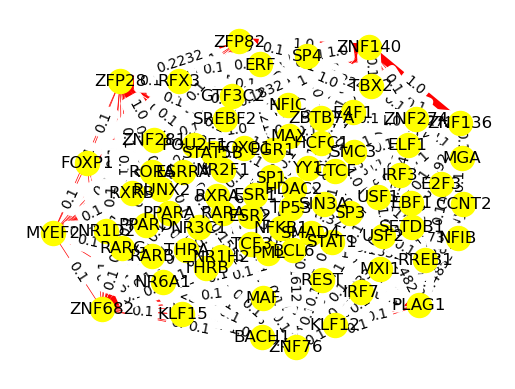

In [45]:
fixed_netrem_2a = nm.netrem(edge_list = filtered_ppi_for_TG, 
                     beta_net = 3,
                     alpha_lasso = 0.001,
                     view_network = True)
fixed_netrem_2a.fit(X_train, y_train)
mse_train = fixed_netrem_2a.test_mse(X_train, y_train)
mse_test = fixed_netrem_2a.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

In [46]:
fixed_netrem_2a.model_nonzero_coef_df # the final # of non-zero predictors. 1 column is added due to y_intercept term. 

,y_intercept,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,EGR1,ELF1,...,USF2,YY1,ZBTB7A,ZFP28,ZNF136,ZNF140,ZNF274,ZNF281,ZNF682,ZNF76
0,None,0.096596,-0.009237,0.085396,-0.083271,0.225887,-0.42595,-0.07387,-0.076801,0.112941,...,-0.119874,0.165508,-0.054092,-0.127078,0.117717,0.14481,-0.075969,0.053424,0.000031,0.220575


In [47]:
fixed_netrem_2a.combined_df

,coef,TF,TG,info,train_mse,beta_net,alpha_lasso,AbsoluteVal_coefficient,Rank,final_model_TFs,TFs_input_to_model,original_TFs_in_X
0,None,y_intercept,ZZZ3,netrem_no_intercept,0.361463,3,0.001,NaN,76,75,77,77
1,0.096596,BACH1,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.096596,34,75,77,77
2,-0.009237,BCL6,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.009237,68,75,77,77
3,0.085396,CCNT2,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.085396,38,75,77,77
4,-0.083271,CTCF,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.083271,40,75,77,77
...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.14481,ZNF140,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.144810,19,75,77,77
72,-0.075969,ZNF274,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.075969,43,75,77,77
73,0.053424,ZNF281,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.053424,56,75,77,77
74,0.000031,ZNF682,ZZZ3,netrem_no_intercept,0.361463,3,0.001,0.000031,75,75,77,77


#### Example 2b: is using user-defined values for  *beta_net* $\beta_{net}$ and LassoCV to find the optimal *alpha_lasso* .
This is the approach Saniya utilized for NetREm for the paper :)

Training MSE: 0.40284765315234555
Testing MSE: 0.6833977664046426


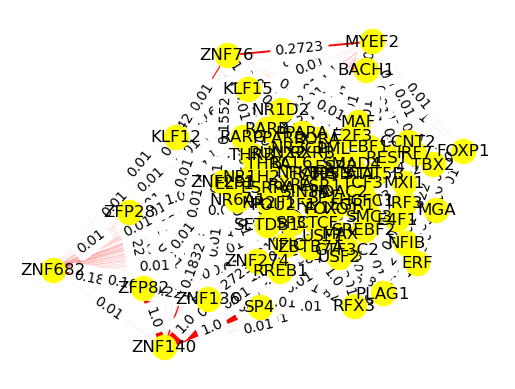

In [76]:
fixed_netrem_2b = nm.netrem(edge_list = filtered_ppi_for_TG, 
                     beta_net = 100,
                    y_intercept = True,
                    default_edge_weight = 0.01,
                    degree_threshold = 0.5,
                     model_type = "LassoCV",
                     view_network = True)
fixed_netrem_2b.fit(X_train, y_train)
mse_train = fixed_netrem_2b.test_mse(X_train, y_train)
mse_test = fixed_netrem_2b.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

In [77]:
fixed_netrem_2b.model_nonzero_coef_df # the final # of non-zero predictors. 1 column is added due to y_intercept term. 

,y_intercept,BACH1,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,ERF,ESR1,...,TP53,USF1,USF2,YY1,ZBTB7A,ZNF136,ZNF140,ZNF274,ZNF682,ZNF76
0,0.06877,0.073128,0.060351,-0.08667,0.174759,-0.170537,-0.045644,0.130413,-0.082457,0.007668,...,-0.089806,0.069805,-0.015188,0.113233,-0.022505,0.056088,0.076585,-0.001909,0.00184,0.109638


In [78]:
fixed_netrem_2b.combined_df

,coef,TF,TG,info,train_mse,beta_net,alpha_lassoCV,AbsoluteVal_coefficient,Rank,final_model_TFs,TFs_input_to_model,original_TFs_in_X
0,0.068770,y_intercept,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.068770,29,67,77,77
1,0.073128,BACH1,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.073128,27,67,77,77
2,0.060351,CCNT2,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.060351,34,67,77,77
3,-0.086670,CTCF,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.086670,19,67,77,77
4,0.174759,E2F3,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.174759,1,67,77,77
...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.056088,ZNF136,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.056088,35,67,77,77
64,0.076585,ZNF140,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.076585,25,67,77,77
65,-0.001909,ZNF274,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.001909,66,67,77,77
66,0.001840,ZNF682,ZZZ3,netrem_with_intercept,0.402848,100,Cross-Validation optimal alpha lasso: 0.004425...,0.001840,67,67,77,77


In [51]:
vars(fixed_netrem_2b).keys()

dict_keys(['info', 'verbose', 'overlapped_nodes_only', 'num_cv_folds', 'num_jobs', 'all_pos_coefs', 'model_type', 'use_network', 'fit_y_intercept', 'max_lasso_iterations', 'view_network', 'model_info', 'target_gene_y', 'tolerance', 'lasso_selection', 'lassocv_eps', 'lassocv_n_alphas', 'lassocv_alphas', 'beta_net', 'network', 'alpha_lasso', 'optimal_alpha', 'prior_network', 'preprocessed_network', 'network_params', 'network_nodes_list', 'kwargs', 'X_df', 'gene_expression_nodes', 'common_nodes', 'final_nodes', 'gexpr_nodes_added', 'gexpr_nodes_to_add_for_net', 'filter_network_bool', 'A_df', 'A', 'nodes', 'network_info', 'M', 'N', 'X_train', 'y_train', 'B_train', 'B_interaction_df', 'B_train_times_M', 'X_tilda_train', 'y_tilda_train', 'X_training_to_use', 'y_training_to_use', 'regr', 'final_alpha', 'coef', 'predY_tilda_train', 'mse_tilda_train', 'predY_train', 'mse_train', 'model_coef_df', 'model_nonzero_coef_df', 'sorted_coef_df', 'corr_vs_coef_df', 'final_corr_vs_coef_df', 'combined_df'

In [52]:
fixed_netrem_2b.get_params()

{'info': 'NetREm Model',
 'alpha_lasso': 'LassoCV finds optimal alpha',
 'beta_net': 100,
 'fit_y_intercept': False,
 'model_type': 'LassoCV',
 'max_lasso_iterations': 10000,
 'network': <PriorGraphNetwork.PriorGraphNetwork at 0x192d3123970>,
 'verbose': False,
 'all_pos_coefs': False,
 'model_info': 'fitted_model :)',
 'target_gene_y': 'ZZZ3',
 'num_cv_folds': 5,
 'num_jobs': -1,
 'lassocv_eps': 0.001,
 'lassocv_n_alphas': 100,
 'lassocv_alphas': None,
 'optimal_alpha': 'Cross-Validation optimal alpha lasso: 0.007758426975961768',
 'tolerance': 0.0001,
 'lasso_selection': 'cyclic'}

In [53]:
fixed_netrem_2b.final_corr_vs_coef_df

,info,input_data,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,...,TP53,USF1,USF2,YY1,ZBTB7A,ZNF136,ZNF140,ZNF281,ZNF682,ZNF76
0,network regression coeff. with y: ZZZ3,X_train,0.087172,0.006197,0.055428,-0.058928,0.15725,-0.131271,-0.027902,0.110304,...,-0.088339,0.048455,-0.000642,0.096839,-0.036242,0.003584,0.066003,0.009297,0.000221,0.059335
0,corr (r) with y: ZZZ3,X_train,0.191081,0.028315,0.134249,-0.053487,0.160718,-0.046865,-0.04716,0.207914,...,-0.065173,0.085353,-0.025491,0.119843,-0.124585,-0.012445,0.132537,0.057205,0.129738,0.124608
0,Absolute Value NetREm Coefficient Ranking,X_train,14,54,25,23,2,4,39,6,...,13,28,59,9,34,57,20,51,60,22


In [54]:
b_matrix_2b = nm.organize_B_interaction_network(fixed_netrem_2b)
b_matrix_2b

,TF1,TF2,B_train_weight,sign,potential_interaction,absVal_B,info,candidate_TFs_N,target_gene_y,num_final_predictors,model_type,beta_net,gene_data,rank,percentile
2092,FOXO1,NFIB,1.118503,:),:(,1.118503,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,1.0,99.982912
1028,NFIB,FOXO1,1.118503,:),:(,1.118503,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,1.0,99.982912
4416,NFIB,SREBF2,0.956641,:),:(,0.956641,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,3.0,99.948735
2136,SREBF2,NFIB,0.956641,:),:(,0.956641,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,3.0,99.948735
1046,RORA,FOXO1,0.928125,:),:(,0.928125,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,5.0,99.914559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,ESRRA,PML,-0.000098,:(,:( competitive (-),0.000098,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,5848.0,0.068353
4708,ESR2,TCF3,-0.000093,:(,:( competitive (-),0.000093,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,5849.0,0.051265
908,TCF3,ESR2,-0.000093,:(,:( competitive (-),0.000093,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,5849.0,0.051265
3386,ZNF682,REST,-0.000089,:(,:( competitive (-),0.000089,B matrix of TF-TF interactions,77,ZZZ3,60,LassoCV,100,training gene expression data,5851.0,0.017088


#### Example 2c: is using GridSearchCV for comprehensive hyperparameter optimization for *beta_net* $\beta_{net}$ and *alpha_lasso* $\alpha_{lasso}$ .

In [55]:
%%time

demo1 = nm.netrem(edge_list = filtered_ppi_for_TG, 
                     view_network = False)

param_grid = {
    'beta_net': [1e-6,3, 0.1, 0.05, 1e-7, 5e-6, 0.01,1e-3, 0.2, 0.4, 0.5, 0.6, 0.8, 5, 1, 2],
   'alpha_lasso': [1e-5, 0.00001, 1e-8, 0.0001, 0.005, 0.001, 1e-9, 0.002, 0.1, 0.0023559, 0.003, 0.005, 0.01]}

griddy_demo1 = GridSearchCV(demo1, param_grid=param_grid, cv=5, n_jobs = -1, verbose = 10)
griddy_demo1.fit(X_train, y_train)

using beta_net default of 1
using alpha_lasso default of 0.01
Fitting 5 folds for each of 208 candidates, totalling 1040 fits
CPU times: total: 11.1 s
Wall time: 24.7 s


GridSearchCV(cv=5,
             estimator=NetREmModel(all_pos_coefs=False, alpha_lasso=0.01, beta_net=1, fit_y_intercept=False, info='NetREm Model', lasso_selection='cyclic', max_lasso_iterations=10000, model_info='unfitted_model :(', model_type='Lasso', network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192D3375720>, target_gene_y='Unknown :(', tolerance=0.0001, verbose=False),
             n_jobs=-1,
             param_grid={'alpha_lasso': [1e-05, 1e-05, 1e-08, 0.0001, 0.005,
                                         0.001, 1e-09, 0.002, 0.1, 0.0023559,
                                         0.003, 0.005, 0.01],
                         'beta_net': [1e-06, 3, 0.1, 0.05, 1e-07, 5e-06, 0.01,
                                      0.001, 0.2, 0.4, 0.5, 0.6, 0.8, 5, 1,
                                      2]},
             verbose=10)

In [56]:
griddy_demo1.best_params_

{'alpha_lasso': 0.1, 'beta_net': 5}

In [57]:
gridsearch_netrem_model = griddy_demo1.best_estimator_
gridsearch_netrem_model

NetREmModel(info=NetREm Model, verbose=False, all_pos_coefs=False, model_type=Lasso, fit_y_intercept=False, max_lasso_iterations=10000, model_info=fitted_model :), target_gene_y=ZZZ3, tolerance=0.0001, lasso_selection=cyclic, beta_net=5, alpha_lasso=0.1, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192D34B3C70>)

In [58]:
gridsearch_netrem_model.get_params()

{'info': 'NetREm Model',
 'alpha_lasso': 0.1,
 'beta_net': 5,
 'fit_y_intercept': False,
 'model_type': 'Lasso',
 'max_lasso_iterations': 10000,
 'network': <PriorGraphNetwork.PriorGraphNetwork at 0x192d85f35b0>,
 'verbose': False,
 'all_pos_coefs': False,
 'model_info': 'fitted_model :)',
 'target_gene_y': 'ZZZ3',
 'tolerance': 0.0001,
 'lasso_selection': 'cyclic'}

In [59]:
print(f":) # of final TFs in the model for TG {tg}: {gridsearch_netrem_model.num_final_predictors}")
mse_train = gridsearch_netrem_model.test_mse(X_train, y_train)
mse_test = gridsearch_netrem_model.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training MSE: 0.5480934127420958
Testing MSE: 0.6610817578852232


#### Example 2d: is using RandomizedSearchCV for more efficient (but less comprehensive) optimization for *beta_net* $\beta_{net}$ and *alpha_lasso* $\alpha_{lasso}$ .

In [60]:
from sklearn.model_selection import RandomizedSearchCV
demo2 = nm.netrem(edge_list = filtered_ppi_for_TG, 
                     view_network = False)

griddy_demo2 = RandomizedSearchCV(demo2, param_distributions=param_grid, cv=5, n_jobs = -1, verbose = 10)
griddy_demo2.fit(X_train, y_train)

using beta_net default of 1
using alpha_lasso default of 0.01
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=NetREmModel(all_pos_coefs=False, alpha_lasso=0.01, beta_net=1, fit_y_intercept=False, info='NetREm Model', lasso_selection='cyclic', max_lasso_iterations=10000, model_info='unfitted_model :(', model_type='Lasso', network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192D34B2DA0>, target_gene_y='Unknown :(', tolerance=0.0001, verbose=False),
                   n_jobs=-1,
                   param_distributions={'alpha_lasso': [1e-05, 1e-05, 1e-08,
                                                        0.0001, 0.005, 0.001,
                                                        1e-09, 0.002, 0.1,
                                                        0.0023559, 0.003, 0.005,
                                                        0.01],
                                        'beta_net': [1e-06, 3, 0.1, 0.05, 1e-07,
                                                     5e-06, 0.01, 0.001, 0.2,
                                                     0.4, 0.5, 0.6, 0.8, 5, 1,
                                                     2]},
                   verbose=10)

In [61]:
griddy_demo2.best_params_

{'beta_net': 0.001, 'alpha_lasso': 0.1}

In [62]:
randsearch_netrem_model = griddy_demo2.best_estimator_
randsearch_netrem_model

NetREmModel(info=NetREm Model, verbose=False, all_pos_coefs=False, model_type=Lasso, fit_y_intercept=False, max_lasso_iterations=10000, model_info=fitted_model :), target_gene_y=ZZZ3, tolerance=0.0001, lasso_selection=cyclic, beta_net=0.001, alpha_lasso=0.1, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192D35200A0>)

In [63]:
print(f":) # of final TFs in the model for TG {tg}: {randsearch_netrem_model.num_final_predictors}")
mse_train = randsearch_netrem_model.test_mse(X_train, y_train)
mse_test = randsearch_netrem_model.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

:) # of final TFs in the model for TG ZZZ3: 12
Training MSE: 0.5480195658517126
Testing MSE: 0.6610360333859123


In [64]:
randsearch_netrem_model.model_nonzero_coef_df

,y_intercept,BACH1,ELF1,FOXO1,FOXP1,MAF,MAX,NFIB,NFKB1,NR3C1,RREB1,SETDB1,YY1
0,None,0.085496,0.118928,0.012787,0.010383,0.026445,0.024701,0.117132,0.052072,0.051238,0.006338,0.083056,0.005714


#### Example 2e: is using Bayesian Optimization and Gaussian Processes to determine the optimal *beta_net* $\beta_{net}$ and *alpha_lasso* $\alpha_{lasso}$  given a potential range of values.


In [65]:
%%time
netrem_bayes_demo2 = nm.netrem(edge_list = filtered_ppi_for_TG, 
                        y_intercept = True)

bayesian_netty2 = nm_eval.optimal_netrem_model_via_bayesian_param_tuner(netrem_bayes_demo2,
                                                                        X_train, y_train,
                                                                       beta_net_min = 1, 
                                                                      beta_net_max = 100, 
                                                                      alpha_lasso_min = 0.0001,
                                                                      alpha_lasso_max = 0.01,                                                 
                                                                      num_grid_values = 50)
bayesian_net_model2 = bayesian_netty2["optimal_model"]
bayesian_net_model2

using beta_net default of 1
using alpha_lasso default of 0.01
:) Please note that we are running: optimal_netrem_model_via_bayesian_param_tuner
alpha_lasso = 0.01 ; beta_network = 100.0
{'info': 'NetREm Model', 'alpha_lasso': 0.01, 'beta_net': 1, 'fit_y_intercept': True, 'model_type': 'Lasso', 'max_lasso_iterations': 10000, 'network': <PriorGraphNetwork.PriorGraphNetwork object at 0x00000192D4AEE260>, 'verbose': False, 'all_pos_coefs': False, 'model_info': 'fitted_model :)', 'target_gene_y': 'ZZZ3', 'tolerance': 0.0001, 'lasso_selection': 'cyclic'}
CPU times: total: 5.61 s
Wall time: 18 s


NetREmModel(info=NetREm Model, verbose=False, all_pos_coefs=False, model_type=Lasso, fit_y_intercept=True, max_lasso_iterations=10000, model_info=fitted_model :), target_gene_y=ZZZ3, tolerance=0.0001, lasso_selection=cyclic, beta_net=1, alpha_lasso=0.01, network=<PriorGraphNetwork.PriorGraphNetwork object at 0x00000192D34B1330>)

In [66]:
bayesian_net_model2.get_params()

{'info': 'NetREm Model',
 'alpha_lasso': 0.01,
 'beta_net': 1,
 'fit_y_intercept': True,
 'model_type': 'Lasso',
 'max_lasso_iterations': 10000,
 'network': <PriorGraphNetwork.PriorGraphNetwork at 0x192d3523b50>,
 'verbose': False,
 'all_pos_coefs': False,
 'model_info': 'fitted_model :)',
 'target_gene_y': 'ZZZ3',
 'tolerance': 0.0001,
 'lasso_selection': 'cyclic'}

In [67]:
print(f":) # of final TFs in the model for TG {tg}: {bayesian_net_model2.num_final_predictors}")
mse_train = bayesian_net_model2.test_mse(X_train, y_train)
mse_test = bayesian_net_model2.test_mse(X_test, y_test)
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

:) # of final TFs in the model for TG ZZZ3: 53
Training MSE: 0.44677196830719673
Testing MSE: 0.7485799905085805


In [68]:
bayesian_net_model2.model_nonzero_coef_df

,y_intercept,BACH1,BCL6,CCNT2,CTCF,E2F3,E4F1,EBF1,ELF1,ERF,...,TCF3,TP53,USF2,YY1,ZBTB7A,ZFP28,ZNF140,ZNF274,ZNF682,ZNF76
0,-0.15667,0.111807,0.002305,0.02496,-0.031419,0.135078,-0.187243,-0.023986,0.091143,-0.013846,...,-0.137879,-0.154464,-0.039146,0.056958,-0.064111,-0.083764,0.118554,-0.019879,0.015135,0.151874


In [69]:
bayesian_net_model2.combined_df

,coef,TF,TG,info,train_mse,beta_net,alpha_lasso,AbsoluteVal_coefficient,Rank,final_model_TFs,TFs_input_to_model,original_TFs_in_X
0,-0.156670,y_intercept,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.156670,3,53,77,77
1,0.111807,BACH1,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.111807,12,53,77,77
2,0.002305,BCL6,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.002305,53,53,77,77
3,0.024960,CCNT2,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.024960,41,53,77,77
4,-0.031419,CTCF,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.031419,37,53,77,77
5,0.135078,E2F3,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.135078,7,53,77,77
6,-0.187243,E4F1,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.187243,1,53,77,77
7,-0.023986,EBF1,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.023986,42,53,77,77
8,0.091143,ELF1,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.091143,17,53,77,77
9,-0.013846,ERF,ZZZ3,netrem_with_intercept,0.446772,1,0.01,0.013846,47,53,77,77


In [70]:
vars(bayesian_net_model2).keys()

dict_keys(['info', 'verbose', 'overlapped_nodes_only', 'num_cv_folds', 'num_jobs', 'all_pos_coefs', 'model_type', 'use_network', 'fit_y_intercept', 'max_lasso_iterations', 'view_network', 'model_info', 'target_gene_y', 'tolerance', 'lasso_selection', 'lassocv_eps', 'lassocv_n_alphas', 'lassocv_alphas', 'beta_net', 'alpha_lasso', 'network', 'optimal_alpha', 'prior_network', 'preprocessed_network', 'network_params', 'network_nodes_list', 'kwargs', 'X_df', 'gene_expression_nodes', 'common_nodes', 'final_nodes', 'gexpr_nodes_added', 'gexpr_nodes_to_add_for_net', 'filter_network_bool', 'A_df', 'A', 'nodes', 'network_info', 'M', 'N', 'X_train', 'y_train', 'B_train', 'B_interaction_df', 'B_train_times_M', 'X_tilda_train', 'y_tilda_train', 'X_training_to_use', 'y_training_to_use', 'regr', 'final_alpha', 'coef', 'intercept', 'predY_tilda_train', 'mse_tilda_train', 'predY_train', 'mse_train', 'model_coef_df', 'model_nonzero_coef_df', 'sorted_coef_df', 'corr_vs_coef_df', 'final_corr_vs_coef_df', 

In [71]:
b_matrix_2e = nm.organize_B_interaction_network(bayesian_net_model2)
b_matrix_2e

,TF1,TF2,B_train_weight,sign,potential_interaction,absVal_B,info,candidate_TFs_N,target_gene_y,num_final_predictors,model_type,beta_net,gene_data,rank,percentile
2092,FOXO1,NFIB,1.119274e+00,:),:(,1.119274e+00,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,1.0,99.982912
1028,NFIB,FOXO1,1.119274e+00,:),:(,1.119274e+00,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,1.0,99.982912
4416,NFIB,SREBF2,9.570243e-01,:),:(,9.570243e-01,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,3.0,99.948735
2136,SREBF2,NFIB,9.570243e-01,:),:(,9.570243e-01,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,3.0,99.948735
1046,RORA,FOXO1,9.287842e-01,:),:(,9.287842e-01,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,5.0,99.914559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,TCF3,RXRB,-1.163842e-06,:(,:( competitive (-),1.163842e-06,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,5847.0,0.085441
960,PML,ESRRA,-9.827955e-07,:(,:( competitive (-),9.827955e-07,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,5849.0,0.051265
2784,ESRRA,PML,-9.827955e-07,:(,:( competitive (-),9.827955e-07,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,5850.0,0.034176
4708,ESR2,TCF3,-9.284305e-07,:(,:( competitive (-),9.284305e-07,B matrix of TF-TF interactions,77,ZZZ3,53,Lasso,1,training gene expression data,5851.0,0.017088
